# Семинар 3
Сегодня речь пойдёт о метрике качества линейной регрессии, проверке обобщающей способности построенной модели, регуляризации и переборных алгоритмах. Семинар вокруг данных о социальных показателях американских муниципальных районов, которые будут использованы для предсказания количества жестоких преступлений на душу населения. Все признаки в датасете - числовые, в данных есть пропуски, но мы пока не обращаем внимания на эту проблему (заполним пропуски средними значениями признаков).

from sklearn.metrics import mean_squared_error as mse

In [1]:
# Не обращаем большого внимания на этот код, на него нет времени
import numpy as np
import pandas as pd
#Загружаем датасет
x = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data',
                header= None,na_values = '?')
#Загружаем и парсим имена признаков
import urllib
text = urllib.request.urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.names')
text = text.read()
text = str(text)
import re
colnames = re.findall(r"@attribute ([a-zA-Z1-90]*) [a-zA-Z]*\\n",text)
#Добавляем имена признаков
x.columns = colnames
#Создаём себе дополнительные проблемы, сортируем выборку по возрастанию целевой переменной
#x = x.sort_values(by='ViolentCrimesPerPop')
#Выкидываем лишние ненужные колонки
x = x.drop(['state','county','community','communityname','fold'],1)
#Заполняем все пропуски в данных средними значениями для каждого признака
from sklearn import preprocessing
mis_replacer = preprocessing.Imputer(strategy="mean")
x = pd.DataFrame(data=mis_replacer.fit_transform(x),columns=x.columns)
#Выделяем вектор y в отдельную переменную 
y = x['ViolentCrimesPerPop']
y = pd.DataFrame(y)
x = x.drop(['ViolentCrimesPerPop'],1)
#x = x.drop(['state','county','community','communityname','fold','ViolentCrimesPerPop','LemasSwFTPerPop'],1)
colnames = x.columns

Также мы изначально разобьем наши данные пополам и пока что будем работать только с одной половиной:

In [2]:
x_tr,y_tr = x.ix[:int(x.shape[0]/2)],y.ix[:int(x.shape[0]/2)]
x_test,y_test = x.ix[int(x.shape[0]/2)+1:],y.ix[int(x.shape[0]/2)+1:]

## Линейная регрессия из коробки

На прошлом семинаре мы много внимания уделили тому, как находится оптимальный вектор весов для линейной регрессии. Сейчас же мы воспользуемся самым простым способом построить регрессию, используя готовые модели из sklearn. Запуская регрессию из коробки, необходимо читать, что [внутри](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [3]:
#Импортируем класс из sklearn
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
#непосредсвенно строим регрессию
lr.fit(x_tr,y_tr)
#Готово!

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Сразу замечаем, что по умолчанию в число регрессоров будет включена и константа. С помощью методов класса, из нашей построенной регрессии можно получить вектор весов $w$:

In [4]:
w = lr.coef_[0]
w = pd.DataFrame({'Имя признака':colnames,'Вес признака':w},columns = ['Имя признака','Вес признака'])
w

,Имя признака,Вес признака
0,population,0.536777
1,householdsize,-0.022001
2,racepctblack,0.259221
3,racePctWhite,-0.113908
4,racePctAsian,-0.032377
5,racePctHisp,0.067059
6,agePct12t21,0.000988
7,agePct12t29,-0.586161
8,agePct16t24,0.112966
9,agePct65up,-0.155960


Построим прогноз $a$ на основе нашей модели:

In [5]:
a = lr.predict(x_tr)
a = pd.DataFrame(a,columns=['prediction'])
# прогноз для первых нескольких объектов
a.head()

,prediction
0,0.206635
1,0.269199
2,0.336777
3,0.380227
4,-0.020468


## $R^2$ - основная метрика качества регрессии

Когда необходимо сравнить по качеству две разных линейных модели, то чаще всего для этого используют метрику $R^2$. Основное преимущество данной метрики: её значение может интерпретироваться. $R^2$ - это с некоторыми оговорками доля дисперсии, объяснённая моделью в общей дисперсии целевой переменной. Данный показатель принимает значения в диапазоне от 0 до 1. Чем он больше, тем лучше построенная модель предсказывает поведение целевой переменной.  

$$R^2 = 1 - \frac{\sum_i (y_i - a(x_i))^2}{\sum_i (y_i - \overline{y}_i)^2} \approx 1 - \frac{\text{Var} (Y|X)}{\text{Var} Y}$$

Теперь посчитаем $R^2$ для построенной нами регрессии:

In [6]:
#первый способ
print('Первый способ: %f' %lr.score(x_tr,y_tr))
#второй способ
import sklearn.metrics as metrics
print('Второй способ: %f' %metrics.r2_score(y_tr,a))

Первый способ: 0.706413
Второй способ: 0.706413


In [7]:
a = lr.predict(x_tr)
a = pd.DataFrame(a,columns=['prediction'])
# прогноз для первых нескольких объектов
a.head()

,prediction
0,0.206635
1,0.269199
2,0.336777
3,0.380227
4,-0.020468


70% объяснённой дисперсии целевой переменной. Много это или мало - зависит от конкретной задачи и от наших субъективных ожиданий.  Если в структуре наших данных почти нет закономерностей и всё подвержено случайным событиям, то ни одна модель не сможет дать нам высокий $R^2$. В таком случае и 15% было бы неплохим результатом.

## Валидация - проверка обобщающей способности


$R^2$, который приведён выше, посчитан на тех данных, на которых была построена регрессия. Но мы хотим, чтобы построенная модель успешно справлялась с прогнозами и на тех на данных, для которых ей неизвестно истинное значение целевой переменной, иначе практическая польза такой модели будет мала. Если модель способна выявить в данных какие-либо закономерности и обобщить их для данных, которые не использовались при её построении, то мы говорим, что она обладает обобщаюей способностью. Проверку обобщающей способности мы назовём валидацией. В конечном счёте, нас интересует $R^2$, который модель покажет на новых данных.

Вспомним об отложенной нами выборке и воспользуемся ей для проверки обобщающей способности.

In [8]:
a_test = lr.predict(x_test)
print('R2 на тестовой выборке: %f' %metrics.r2_score(y_test,a_test))

R2 на тестовой выборке: -27.348416


### Подводные камни

"Oops... something went wrong...": $R^2$ оказался отрицательным. Как это произошло? Обратим внимание на дробь:

$$R^2 = 1 - \frac{\sum_i (y_i - a(x_i))^2}{\sum_i (y_i - \overline{y}_i)^2} \approx 1 - \frac{\text{Var} (Y|X)}{\text{Var} Y}$$

В ней дисперсия целевой переменной при нашей модели сравнивается с обычной дисперсией. Обычную дисперсию можно представить как условную дисперсию целевой переменной в *"базовой"* модели, которая рисует горизонтальную прямую на уровне $\bar{y}$. Выходит, что для регрессий, которые справляются с предсказанием хуже, чем базовая регрессия, зашитая прямо в формулу данной метрики, $R^2$ выдает отрицательный результат:

![pictcha](https://raw.githubusercontent.com/FilatovArtm/ML_Eco-NES_2017/master/seminars/maintain/sem3picture.png)

Таким образом, мы, решив провести валидацию, сразу поняли, что на новой выборке наша модель хуже, чем отсутствие модели вообще (прогноз $a(.)=\bar{y}$ не требует данных для построения). Поэтому обобщающая способность нашей модели равна нулю. К счастью, проблему можно решить. Посмотрим на вектор $w$ ещё раз, при этом отсортировав:

In [9]:
w.sort_values(by= 'Вес признака')

,Имя признака,Вес признака
103,PolicPerPop,-3735.168122
10,numbUrban,-0.751070
79,OwnOccLowQuart,-0.702989
7,agePct12t29,-0.586161
63,PctLargHouseOccup,-0.575794
21,whitePerCap,-0.513258
81,OwnOccHiQuart,-0.426227
65,PersPerOwnOccHous,-0.360409
51,NumImmig,-0.288987
100,LemasTotalReq,-0.274058


И сразу замечаем, что у 1-ого регрессора в данном списке очень маленькое значение по сравнению с другими. А если обратим внимание на дно данного списка, то заметим брата-близнеца данного регрессора, имеющего очень большое значение и по модулю равное ему! В этот момент мы понимаем в чём дело. Похоже в нашей матрице "объекты-признаки" есть линейно-зависимые регрессоры. Посмотрим на корреляцию между ними: 

In [10]:
np.corrcoef(x_tr['PolicPerPop'],x_tr['LemasSwFTPerPop'])[0,1]

0.99999998504486121

Корреляция близка к единице. Следовательно, в наших данных два почти одинаковых регрессора.

Что будет, если включить в модель линейно-зависимые признаки? Приведем пример. Пусть мы имеем дело с *истинной зависимостью*:

$$y_i=7+2p_i+3q_i+4r_i,$$

где истинный вектор весов имеет вид $w=(w_0,w_1,w_2,w_3)^T=(7,2,3,4)$. Пусть переменные $q_i$ и $r_i$ всегда одинаковы:

$$q_i=r_i$$ 

Тогда существует бесконечное число комбинаций $w_2$ и $w_3$, которые нам всё равно бы подошли. Например, возьмём комбинацию $w*=(7,2,-2000,2007)$:

$$7+2p_i-2000q_i+2007r_i\\7+2p_i-2000q_i+2007q_i\\7+2p_i+7q_i\\7+2p_i+3q_i+4q_i\\7+2p_i+3q_i+4r_i=y_i$$

Поэтому нам всё равно, какой вектор из бесконечного числа комбинаций взять. И обычно компьютер выбирает тот, в котором веса очень большие. А это означает, что если в новой выборке найдутся объекты, у которых данные регрессоры будут отличаться чуть больше, чем в обучающей выборке, то это будет катастрофически влиять на значение $y$ у таких объектов, далеко отбрасывая их даже от $\bar{y}$. В эконометрике данное явление называется мультиколлинеарностью, и мы рассмотрели его лишь с одной стороны.  

__Решение проблемы:__ Мы посмотрели описания признаков "PolicPerPop" и "LemasSwFTPerPop" и обнаружили, что они означают почти одно и то же (число полицейских на душу населения), поэтому мы просто удалили один из признаков.

In [11]:
x = x.drop(['LemasSwFTPerPop'],1)
colnames  = x.columns

In [12]:
x_tr,y_tr = x.ix[:int(x.shape[0]/2)],y.ix[:int(x.shape[0]/2)]
x_test,y_test = x.ix[int(x.shape[0]/2)+1:],y.ix[int(x.shape[0]/2)+1:]

Построим регрессию вновь и обнаружим, что теперь она приобрела обобщающую способность:

In [13]:
lr.fit(x_tr,y_tr)
w = lr.coef_[0]
w = pd.DataFrame({'Имя признака':colnames,'Вес признака':w},columns = ['Имя признака','Вес признака'])

a = lr.predict(x_tr)
a_test = lr.predict(x_test)
print('R2 на обучающей выборке: %f' %metrics.r2_score(y_tr,a))
print('R2 на тестовой выборке: %f' %metrics.r2_score(y_test,a_test))


R2 на обучающей выборке: 0.703947
R2 на тестовой выборке: 0.616290


### Перемешивание объектов
Данный случай показывает, как важно проводить валидацию модели. Но на самом деле, проведенный нами тест до сих пор не совсем точен. Мы разделили первичный датасет простым правилом (просто пополам), которое не гарантирует, что полученные подвыборки будут эквивалентны друг другу. Приведем простой пример. Пусть нам достался датасет, в котором все объекты отсортированы по возрастанию целевой переменной: 

In [14]:
#x = x.sort_values(by='ViolentCrimesPerPop')
x_sorted = x.copy()
x_sorted['y'] = y.ViolentCrimesPerPop
x_sorted = x_sorted.sort_values(by='y')
y_sorted = x_sorted['y']
x_sorted = x_sorted.drop(['y'],1)

In [15]:
x_tr,y_tr = x_sorted.ix[:int(x.shape[0]/2)],y_sorted.ix[:int(x.shape[0]/2)]
x_test,y_test = x_sorted.ix[int(x.shape[0]/2)+1:],y_sorted.ix[int(x.shape[0]/2)+1:]

Теперь построим модель на новой обучающей выборке и посмотрим на её метрику качества:

In [16]:
lr.fit(x_tr,y_tr)
print('R2 на обучающей выборке: %f' %lr.score(x_tr,y_tr))
print('R2 на тестовой выборке: %f' %lr.score(x_test,y_test))

R2 на обучающей выборке: 0.344850
R2 на тестовой выборке: 0.000000


Данные в обучающей и валидационной выборке тепеь имеют на столько разную структуру, что это сказалось на $R^2$ для тестовой выборки. Чтобы правильно провести валидацию модели, нужно чтобы обе выборки были похожи друг на друга. Поэтому всегда рекомендуется перемешать объекты в исходном датасете, прежде чем делить его на обучающую и тестовую выборку.

In [17]:
from sklearn.model_selection import train_test_split
# random_state отвечает за зерно для генератора случайных чисел
x_tr, x_test, y_tr, y_test = train_test_split(x_sorted, y_sorted,test_size=int(x.shape[0]/2),random_state = 123)

x_sorted = x.copy()
x_sorted['y'] = y.ViolentCrimesPerPop
x_sorted = x_sorted.sort_values(by='y')
y_sorted = x_sorted['y']
x_sorted = x_sorted.drop(['y'],1)

lr.fit(x_tr,y_tr)
print('R2 на обучающей выборке: %f' %lr.score(x_tr,y_tr))
print('R2 на тестовой выборке: %f' %lr.score(x_test,y_test))

R2 на обучающей выборке: 0.713445
R2 на тестовой выборке: 0.617914


### Повышение устойчивости метрики
Мы видим, что снова $R^2$ вернулся к прошлому значению. Хотя значения до и после сортировки немного разнятся. Чтобы повысить устойчивость оценки качества, можно проводить разбиение выборки на обучающую и тестовую не один, а $N$ раз, после чего усреднять результаты, полученные на $N$ контрольных выборках. Для этого можно использовать функцию ShuffleSplit:

In [18]:
from sklearn.model_selection import ShuffleSplit
# разобьём датасет на пополам 5 раз и возьмём средний R2
# random_state отвечает за зерно для генератора случайных чисел
cv = ShuffleSplit(n_splits=5, test_size=0.5, random_state=123)

quals = []
for tr_ind, test_ind in cv.split(x):
    lr.fit(x.ix[tr_ind], y.ix[tr_ind])
    quals.append(lr.score(x.ix[test_ind],y.ix[test_ind]))
print('средний R2 на тестовой выборке: %f' %np.mean(quals))

средний R2 на тестовой выборке: 0.611955


### Оптимизация размера обучающей и тестовой выборки
Последний способ уже достаточно хорошо справляется с валидацией. Однако все объекты, которые пришлось исключить из обучающей выборки, содержат в себе ценную информацию, которая не используется при построении модели. В конечном счёте наша итоговая модель всё равно будет использовать все доступные нам данные, и она будет отличаться от той модели, валидацию которой мы проводим сейчас. Поэтому, хотя валидация нашей текущей модели проведена корректно, прогноз обобщающей способности для нашей итоговой модели пессимистично занижен. Попробуем быть более оптимистичными :)

Например, если у нас достаточно много объектов в выборке ($l=1994$), то оправлять половину из них в тестовую выборку - неоправданное расточительство. С другой стороны, оставление в ней слишком маленькой доли объектов может привести к неустойчивости метрики, поэтому нужно выбрать оптимальные пропорции обоих выборок.

Посмотрим, как меняется вариация и среднее метрики в зависимости от доли объектов, отправленной в тестовую выборку:

In [19]:
grid = [0.5,0.4,0.3,0.2,0.15,0.1,0.05] 
table = pd.DataFrame()
mean = []
stdeviation = []

for q in grid:
    print(q)
    # random_state отвечает за зерно для генератора случайных чисел
    cv = ShuffleSplit(n_splits=50, test_size=q,random_state= 123) 
    quals = []
    for tr_ind, test_ind in cv.split(x):
        lr.fit(x.ix[tr_ind], y.ix[tr_ind])
        quals.append(lr.score(x.ix[test_ind],y.ix[test_ind]))
    stdeviation.append(np.std(quals))
    mean.append(np.mean(quals))

    
table['Доля тестовой части'] = grid
table['Мат. ожидание R2'] = mean
table['Ст. отклонение R2'] = stdeviation

0.5
0.4
0.3
0.2
0.15
0.1
0.05


In [20]:
table

,Доля тестовой части,Мат. ожидание R2,Ст. отклонение R2
0,0.50,0.607416,0.022585
1,0.40,0.616874,0.029127
2,0.30,0.627450,0.033079
3,0.20,0.639197,0.033502
4,0.15,0.645398,0.037471
5,0.10,0.643811,0.050088
6,0.05,0.640761,0.075379


Мы видим, что стандартное отклонение метрики увеличивается, что показывает возрастающую неустойчивость метрики. Мы будем в дальнейшем разбивать наши данные в пропорции 80\20, поскольку она выглядит оптимальной: в обучающей выборке объектов побольше, но метрика на тестовой выборке достаточно устойчива.

 ### Kfold cross-validation

Часто мы хотим, чтобы все объекты побывали в обучающей выборке, причем одинаковое число раз. В таком случае модель будет в равной мере использовать для обучения все объекты из выборки. Чтобы удовлетворить этому условию, можно использовать схему K-fold кросс-валидации, реализованную в качестве объекта sklearn.cross_validation.KFold.

![alt text][cv]

[cv]: https://raw.githubusercontent.com/ritchieng/machine-learning-dataschool/master/images/07_cross_validation_diagram.png "cv"
В данном случае выборка разбивается на $K$ (примерно) одинаковых блоков, каждый из которых поочередно выступает в качестве контрольной выборки, а оставшиеся $K-1$ — в качестве обучающей, после чего оценки качества усредняются:
$$Q_{K-fold}(X) = \frac{1}{K} \sum_{k=1}^K Q(X^k; a_{X \backslash X^k }),$$

где $X^k, k = \overline{1, K}$ — непересекающиеся блоки, на которые разбивается выборка $X$: $X = \sqcup_{k=1}^K X^k.$

In [21]:
from sklearn import cross_validation
cv = cross_validation.KFold(n=x.shape[0], n_folds=10, random_state=123, shuffle=True)
quals = []
for tr_ids, test_ids in cv:
    lr.fit(x.iloc[tr_ids], y.iloc[tr_ids])
    quals.append(lr.score(x.iloc[test_ids],y.iloc[test_ids]))

print("K-fold accuracy =", np.mean(quals))

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


K-fold accuracy = 0.635046118068


Кросс-валидация часто используется на маленьких выборках, в которых каждый объект на счету. Иногда применяется способ Leave One Out (sklearn.cross_validation.LeaveOneOut), когда в контрольную выборку попадаёт только один объект, каждый по очереди, пока все в ней не побывают.

## Переобучение

![alt text][cv]

[cv]: https://upload.wikimedia.org/wikipedia/commons/thumb/0/0c/Spurious_correlations_-_spelling_bee_spiders.svg/1040px-Spurious_correlations_-_spelling_bee_spiders.svg.png "wikipedia"
Теперь давайте поговорим о том, почему $R^2$ на тестовой выборке всегда ощутимо ниже, чем на обучающей.

Скольких точек должно хватить для того, чтобы построить прямую? Плоскость? 3-хмерную гиперплоскость? N-мерную гиперплоскость? Какой $R^2$ будет у модели, в которой количество объектов $l$ совпадает с количеством регрессоров $d$? В такой модели при построении будет необходимо разместить единую $d$-мерную плоскость как можно ближе к $l=d$ объектам. Очевидно, что в таком случае всегда удастся подобрать плоскость, которая будет максимально близко ко всем объектам сразу (объекты будут попросту лежать на ней). Поэтому если в выборке $L$ не окажется двух одинаковых объектов с разным значением целевой переменной, то такая модель всего-навсего закодирует через регрессоры все $y_i$ объектов этой выборки:

In [22]:
x_fullfree,y_fullfree = x.ix[:x.shape[1]],y.ix[:x.shape[1]] # напоминаем: в shape 0 - это строки, 1 - столбцы
x_fftest,y_fftest = x.ix[x.shape[1]+1:],y.ix[x.shape[1]+1:]

lr.fit(x_fullfree,y_fullfree)
print('R2 на обучающей выборке: %f' %lr.score(x_fullfree,y_fullfree))
print('R2 на тестовой выборке: %f' %lr.score(x_fftest,y_fftest))

R2 на обучающей выборке: 1.000000
R2 на тестовой выборке: -156.400261


Но как мы видим на тестовой выборке, такой "код" полностью бесполезен. Это утрированный пример полного переобучения модели. Каждый вновь добавленный регрессор может содержать или не содержать полезную информацию о свойствах объектов, но ещё одну степень свободы для более лучшей подгонки модели под выборку он всегда с собой прихватит! В этом и смысл переобучения, которое угрожает не только семейству линейных моделей. Объект, на котором модель обучалась, содержит в себе информацию, которая является частью сущности модели, поэтому поведение данного объекта модель всегда предсказывает всегда лучше, чем если бы он не был включён в обучение. Каждый дополнительный параметр, которым настраивается частная реализация некоторого семейства моделей, является степенью свободы. Каждая степень свободы обеспечивает необходимую гибкость в построении моделей и обеспечивает их разнообразие внутри семейства, но "слишком гибкая модель перегибает палку".

Ещё одна причина переобучения - случайные закономерности, которые встречаются в обучающей выборке, но уже не встречаются в тестовой. В качестве примера приведем картинку с википедии из начала этого раздела. Бороться с этой причиной можно увеличением объектов в обучающей выборке, что мы сделали ранее.

Данный эффект сказывается и на нашей самой пока что адекватной модели, с оптимальными соотношениями обучающей и тестовой выборки и с кросс-валидацией. Давайте посмотрим на него. Для этого отразим поведение $R^2$ на обучающей и тестовой выборке с добавлением новых регрессоров:

In [23]:
train_r2_dynamics = []
test_r2_dynamics = []

cv = cross_validation.KFold(n=x.shape[0], n_folds=10, random_state=123, shuffle=True)
for d in range(x.shape[1]):
    if d % 10 == 0:
        print('Сколько осталось ждать: %s/%s' % (d,x.shape[1]))
    train_r2 = []
    test_r2 = []
    for train_ids, test_ids in cv:
        lr.fit(x.iloc[train_ids,0:d+1], y.iloc[train_ids])
        train_r2.append(lr.score(x.iloc[train_ids,0:d+1],y.iloc[train_ids]))
        test_r2.append(lr.score(x.iloc[test_ids,0:d+1],y.iloc[test_ids]))
    train_r2_dynamics.append(np.mean(train_r2))
    test_r2_dynamics.append(np.mean(test_r2))

Этап работы кода: 0/121
Этап работы кода: 10/121
Этап работы кода: 20/121
Этап работы кода: 30/121
Этап работы кода: 40/121
Этап работы кода: 50/121
Этап работы кода: 60/121
Этап работы кода: 70/121
Этап работы кода: 80/121
Этап работы кода: 90/121
Этап работы кода: 100/121
Этап работы кода: 110/121
Этап работы кода: 120/121


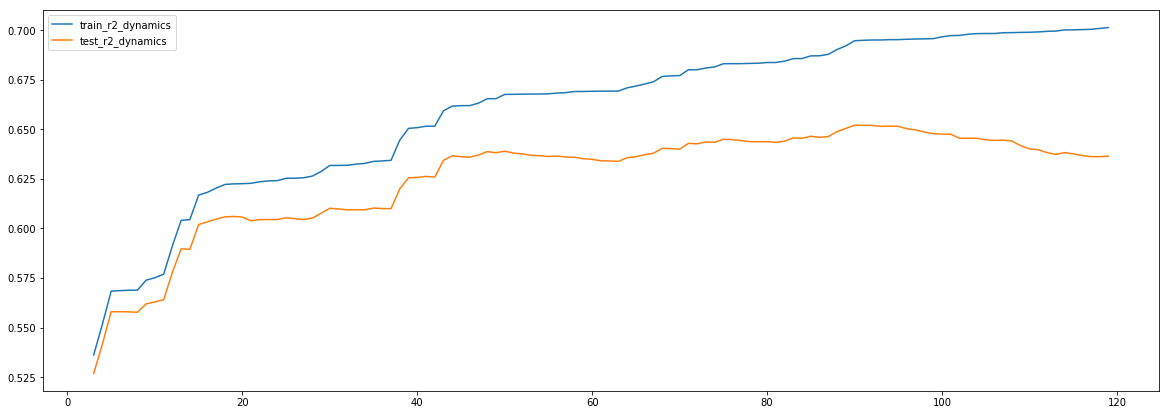

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 7))
i1 = 3
i2 = 120
plt.plot(range(x.shape[1])[i1:i2],train_r2_dynamics[i1:i2],label= 'train_r2_dynamics')
plt.plot(range(x.shape[1])[i1:i2],test_r2_dynamics[i1:i2],label= 'test_r2_dynamics')
plt.legend()


Мы видим, что:
* $R^2$ на обучающей выборке растёт всегда. 
* Где-то с 90-ого вновь добавленного регрессора модель слишком сильно подогналась под обучающую выборку и $R^2$ на новых данных начинает падать.
* Всегда наблюдается разрыв между $R^2$ на train и test. **Именно это** мы называем эффектом **переобучения.**
* Разрыв между метриками возрастает. Это означает, что с добавлением регрессоров модель теряет способность обобщать найденные закономерности на новые данные. (Ну, вы поняли, **обобщающую способность**.)

Поэтому напрашивается вывод - на 90-ста первых регрессорах модель делает свою работу лучше, чем на 120-ти.

In [25]:
for d in [90,x.shape[1]]:
    train_r2 = []
    test_r2 = []
    for train_ids, test_ids in cv:
        lr.fit(x.iloc[train_ids,0:d+1], y.iloc[train_ids])
        train_r2.append(lr.score(x.iloc[train_ids,0:d+1],y.iloc[train_ids]))
        test_r2.append(lr.score(x.iloc[test_ids,0:d+1],y.iloc[test_ids]))
    print('R2 для модели с %s регрессорами: %f' % (d,np.mean(test_r2)))

R2 для модели с 90 регрессорами: 0.652074
R2 для модели с 121 регрессорами: 0.635046


Но торопиться переходить к модели с 90-регрессорами мы пока не будем.

## Регуляризация

Несмотря на то, что модель за 90 явно начинает страдать от большого числа степеней свободы, это не значит, что оставшиеся 30 регрессоров не содержат никакой полезной информации, которую они могли бы привнести в неё. Мы можем попытаться "выжать" её из них. Для этого давайте штрафовать функционал качества за слишком большие значения весов $w_j$:
* $L_1$ регуляризация, или Lasso-регрессия: $$ Q(w) = \frac{1}{l}||Xw-y||^2+\alpha\sum_{j=1}^d{w_j^2} \rightarrow min$$
* $L_2$ регуляризация, или Ridge-регрессия: $$ Q(w) = \frac{1}{l}||Xw-y||^2+\alpha\sum_{j=1}^d{|w_j|} \rightarrow min$$

Из лекций мы знаем, что переобучение нередко приводит к большим значениям коэффициентов. Такие решения не очень хороши, поскольку модель будет чувствительная к крайне маленьким изменениям в признаках объекта, а значит, переобучен. Включение штрафа заставит модель со скептицизмом относиться к большим значениям весов. $\alpha$ - это гиперпараметр модели, который регулирует уровень её скептицизма.

Возьмём для примера $\alpha_1 = 0.0015$ и $\alpha_2 = 1$ и построим регрессии с обоими типами регуляризаций:

In [165]:
# на сей раз лучше уж весь пакет импортируем :)
import sklearn

train_r2_dynamics = []
test_r2_dynamics = []
l1_r2_dynamics = []
l2_r2_dynamics = []

l1lr = sklearn.linear_model.Lasso(alpha = 0.0015)
l2lr = sklearn.linear_model.Ridge(alpha = 3)

cv = cross_validation.KFold(n=x.shape[0], n_folds=10, random_state=123, shuffle=True)
for d in range(x.shape[1]):
    if d % 10 == 0:
        print('Этап работы кода: %s/%s' % (d,x.shape[1]))
    ### ### ###   
    train_r2 = []
    test_r2 = []
    l1_r2 = []
    l2_r2 = []
    ### ### ###
    for train_ids, test_ids in cv:
        lr.fit(x.iloc[train_ids,0:d+1], y.iloc[train_ids])
        l1lr.fit(x.iloc[train_ids,0:d+1], y.iloc[train_ids])
        l2lr.fit(x.iloc[train_ids,0:d+1], y.iloc[train_ids])
        ### ### ###
        train_r2.append(lr.score(x.iloc[train_ids,0:d+1],y.iloc[train_ids]))
        test_r2.append(lr.score(x.iloc[test_ids,0:d+1],y.iloc[test_ids]))
        l1_r2.append(l1lr.score(x.iloc[test_ids,0:d+1],y.iloc[test_ids]))
        l2_r2.append(l2lr.score(x.iloc[test_ids,0:d+1],y.iloc[test_ids]))
    ### ### ###
    train_r2_dynamics.append(np.mean(train_r2))
    test_r2_dynamics.append(np.mean(test_r2))
    l1_r2_dynamics.append(np.mean(l1_r2))
    l2_r2_dynamics.append(np.mean(l2_r2))

Этап работы кода: 0/121
Этап работы кода: 10/121
Этап работы кода: 20/121
Этап работы кода: 30/121
Этап работы кода: 40/121
Этап работы кода: 50/121
Этап работы кода: 60/121
Этап работы кода: 70/121
Этап работы кода: 80/121
Этап работы кода: 90/121
Этап работы кода: 100/121
Этап работы кода: 110/121
Этап работы кода: 120/121


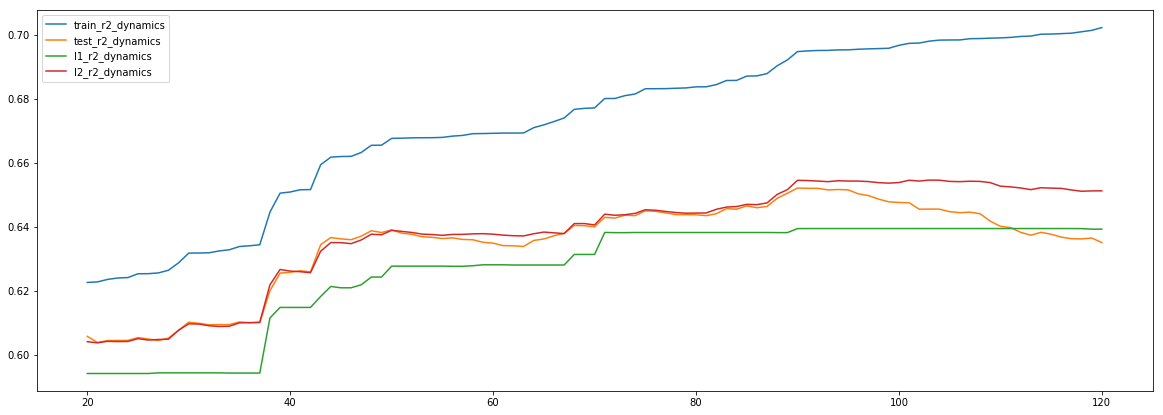

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 7))
i1 = 20
i2 = 121
plt.plot(range(x.shape[1])[i1:i2],train_r2_dynamics[i1:i2],label= 'train_r2_dynamics')
plt.plot(range(x.shape[1])[i1:i2],test_r2_dynamics[i1:i2],label= 'test_r2_dynamics')
plt.plot(range(x.shape[1])[i1:i2],l1_r2_dynamics[i1:i2],label= 'l1_r2_dynamics')
plt.plot(range(x.shape[1])[i1:i2],l2_r2_dynamics[i1:i2],label= 'l2_r2_dynamics')
plt.legend()

Мы видим, что:
* процесс переобучения модели удаётся замедлить с помощью обоих типов регуляризации;
*  при параметре $\alpha = 1$ ridge-регрессия определённо лучше обычной регрессии;
*  при параметре $\alpha = 0.0015$ lasso-регрессия хуже справляется с прогнозом чем обычная регрессия;
*  динамика метрики для lass-регрессии возрастает рывками. Кто значет **почему**?

# Дополнительное 
## Поиск оптимального $\alpha$ по сетке значений

Очевидно, что $\alpha$ нужно настраивать. Но сделать это по обучающей выборке нельзя (оптимальное $\alpha$ на ней равно нулю). Поэтому придётся использовать новые данные (из валидационной выборки), которые мы использовали раньше только для проверки обобщающей способности. Но так как гиперпараметр влияет на сущность модели, а значение гиперпараметра зависит от данных из валидационной выборки, то валидационная выборка становится частью её сущности, что автоматически дискредитирует валидационную выборку. Поэтому для настройки $\alpha$ нужно использовать не те же самые данные, которые будут использоваться для итоговой проверки обобщающей способности.

Поэтому, если мы хотим усовершенствовать нашу модель, добавив в неё настроенную регуляризацию, то мы разделим выборку ещё более сложным способом:

![alt text][pict3]

[pict3]: https://github.com/FilatovArtm/ML_Eco-NES_2017/blob/master/seminars/maintain/sem3picture%202.jpg?raw=true "wikipedia"

Валидационная выборка будет использоваться для настройки гиперпараметров и разбиваться в кросс-валидацию. Тестовая выборка будет использоваться для финальной проверки обобщающей способности, чтобы мы понимали, какой $R^2$ нам нужно будет ожидать от нашей отпимизированной модели. По уже указанным причинам, разобьем исходный датасет в соотношениии 80 на 20.

In [28]:
x_valid, x_test, y_valid, y_test = train_test_split(x_sorted, y_sorted,test_size=int(x.shape[0]*0.2),random_state = 132)

Для оптимизации $\alpha$ создадим сетку значений и заставим python пробежаться по всем из них, построив для каждого значения модель и метрику качества на ней тестовому куску:

In [ ]:
sklearn.model_selection.GridSearchCV

In [145]:
alphagrid = np.linspace(0.1,10,40)
l2_r2_byalpha = []

cv = cross_validation.KFold(n=x_valid.shape[0], n_folds=10, random_state=123, shuffle=True)
for alphai in alphagrid:
    l2_r2 = []
    for train_ids, test_ids in cv:
        l2lr = sklearn.linear_model.Ridge(alpha = alphai)
        l2lr.fit(x_valid.iloc[train_ids,:], y_valid.iloc[train_ids])
        l2_r2.append(l2lr.score(x_valid.iloc[test_ids,:],y_valid.iloc[test_ids]))
    l2_r2_byalpha.append(np.mean(l2_r2))
        

Тоже самое можно сделать, просто пользуясь встроенной функцией (которую всё равно нужно настроить) из sklearn:

In [146]:
from sklearn.model_selection import GridSearchCV
parameters = {'alpha': np.linspace(0.1,10,40)}
l2lr = sklearn.linear_model.Ridge()
alphaopt = GridSearchCV(l2lr, parameters,cv = cv,scoring='r2')
alphaopt.fit(x_valid,y_valid)

gridopt2 = pd.DataFrame(alphaopt.cv_results_)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=1596, n_folds=10, shuffle=True, random_state=123),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  0.1    ,   0.35385,   0.60769,   0.86154,   1.11538,   1.36923,
         1.62308,   1.87692,   2.13077,   2.38462,   2.63846,   2.89231,
         3.14615,   3.4    ,   3.65385,   3.90769,   4.16154,   4.41538,
         4.66923,   4.92308,   5.17692,   5.43077,   5.68462...23,   8.22308,   8.47692,   8.73077,   8.98462,
         9.23846,   9.49231,   9.74615,  10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=0)

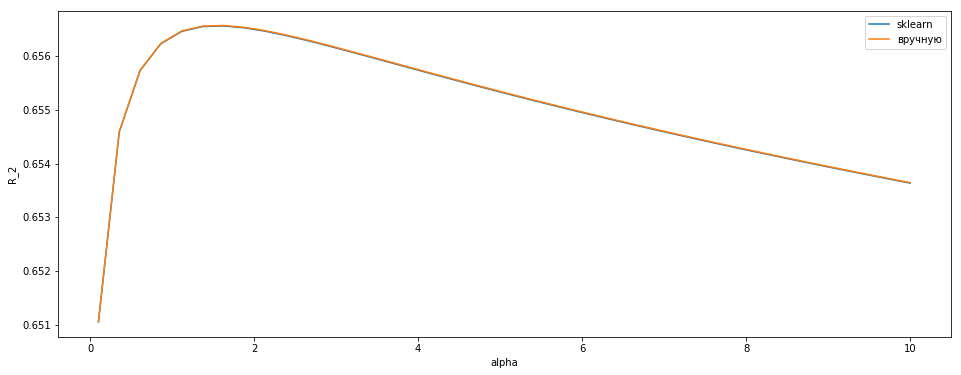

In [153]:
plt.figure(figsize=(16,6))
plt.plot(gridopt2.param_alpha,gridopt2.mean_test_score,label='sklearn')
plt.plot(alphagrid,l2_r2_byalpha,label = 'вручную')
plt.xlabel('alpha')
plt.ylabel('R_2')
plt.legend()

In [154]:
gridopt.sort_values(by='r_2',ascending=False).head()

,alpha,r_2
7,1.876923,0.660389
8,2.130769,0.660378
6,1.623077,0.660350
9,2.384615,0.660336
10,2.638462,0.660271


## Проблема оптимального набора регрессоров
Пересчитаем динамику $R^2$ при добавлении новых регрессоров для регуляризации $\alpha_{\text{old}}=3$ и $\alpha_{\text{new}}=1.5$ (теперь на валидационной выборке):

In [172]:
test_r2_dynamics = []
l2old_r2_dynamics = []
l2new_r2_dynamics = []

l2lrold = sklearn.linear_model.Ridge(alpha = 3)
l2lrnew = sklearn.linear_model.Ridge(alpha = 1.5)

cv = cross_validation.KFold(n=x_valid.shape[0], n_folds=10, random_state=123, shuffle=True)
for d in range(x.shape[1]):
    if d % 10 == 0:
        print('Этап работы кода: %s/%s' % (d,x_valid.shape[1]))
    ### ### ###   
    test_r2 = []
    l2old_r2 = []
    l2new_r2 = []
    ### ### ###
    for train_ids, test_ids in cv:
        lr.fit(x_valid.iloc[train_ids,0:d+1], y_valid.iloc[train_ids])
        l2lrold.fit(x_valid.iloc[train_ids,0:d+1], y_valid.iloc[train_ids])
        l2lrnew.fit(x_valid.iloc[train_ids,0:d+1], y_valid.iloc[train_ids])
        ### ### ###
        test_r2.append(lr.score(x_valid.iloc[test_ids,0:d+1],y_valid.iloc[test_ids]))
        l2old_r2.append(l2lrold.score(x_valid.iloc[test_ids,0:d+1],y_valid.iloc[test_ids]))
        l2new_r2.append(l2lrnew.score(x_valid.iloc[test_ids,0:d+1],y_valid.iloc[test_ids]))
    ### ### ###
    test_r2_dynamics.append(np.mean(test_r2))
    l2old_r2_dynamics.append(np.mean(l2old_r2))
    l2new_r2_dynamics.append(np.mean(l2new_r2))

Этап работы кода: 0/121
Этап работы кода: 10/121
Этап работы кода: 20/121
Этап работы кода: 30/121
Этап работы кода: 40/121
Этап работы кода: 50/121
Этап работы кода: 60/121
Этап работы кода: 70/121
Этап работы кода: 80/121
Этап работы кода: 90/121
Этап работы кода: 100/121
Этап работы кода: 110/121
Этап работы кода: 120/121


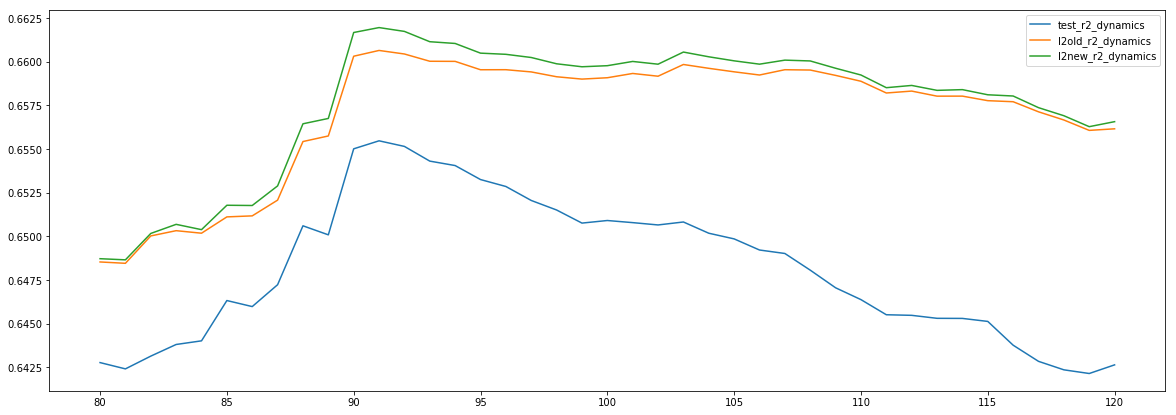

In [173]:
plt.figure(figsize=(20, 7))
i1 = 80
i2 = 121
plt.plot(range(x.shape[1])[i1:i2],test_r2_dynamics[i1:i2],label= 'test_r2_dynamics')
plt.plot(range(x.shape[1])[i1:i2],l2old_r2_dynamics[i1:i2],label= 'l2old_r2_dynamics')
plt.plot(range(x.shape[1])[i1:i2],l2new_r2_dynamics[i1:i2],label= 'l2new_r2_dynamics')
plt.legend()

Мы видим, что значение метрики на модели со всеми регрессорами улучшилось не значительно. Вместе с тем, даже оптимизация $\alpha$ не позволяет остановить ухудшение метрики при добавлении новых регрессоров. Сразу видно, что есть очень простой способ построить более качественную модель: остановиться только на первых 90-а регрессорах, когда модель еще не слишком переобучена.

Однако, порядок, в который выстроены регрессоры в нашей таблице - ничем не обоснован. Посмотрим, какой могла бы быть динамика метрики на тестовой выборке, при 5 других случайных порядках:

In [239]:
lr = LinearRegression()
import random
orders = []
r2testbyorder = []
for k in range(5):
    orders.append(random.sample(range(x_valid.shape[1]),x_valid.shape[1]))
    r2testbyorder.append([])

k = 0
cv = cross_validation.KFold(n=x_valid.shape[0], n_folds=10, random_state=13, shuffle=True)

for order in orders:
    x_differentorder = x_valid.ix[:,order]
    
    for d in range(x_differentorder.shape[1]):
        test_r2 = []
        for train_ids, test_ids in cv:
            lr.fit(x_differentorder.iloc[train_ids,0:d+1], y_valid.iloc[train_ids])
            test_r2.append(lr.score(x_differentorder.iloc[test_ids,0:d+1],y_valid.iloc[test_ids]))
        r2testbyorder[k].append(np.mean(test_r2))
    print('Сколько осталось ждать: %s/%s' % (k+1,5))
    k = k+1 

Сколько осталось ждать: 1/5
Сколько осталось ждать: 2/5
Сколько осталось ждать: 3/5
Сколько осталось ждать: 4/5
Сколько осталось ждать: 5/5


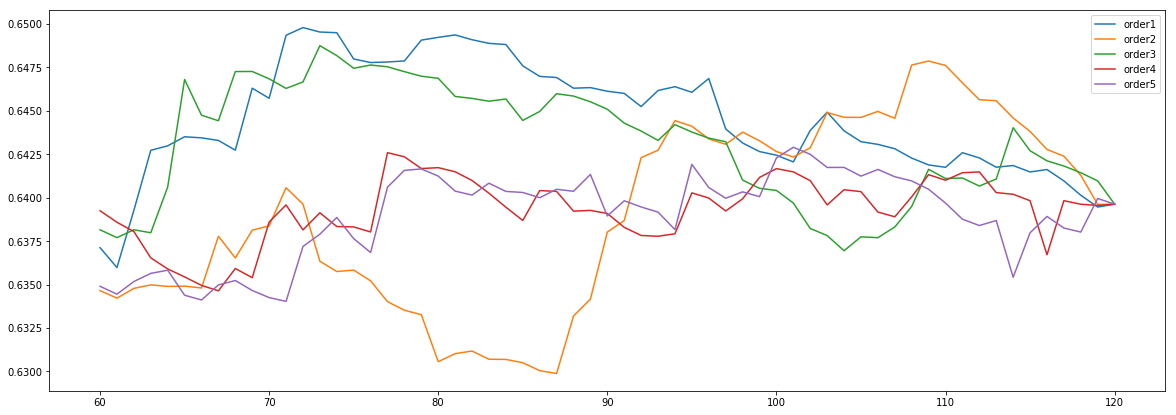

In [243]:
plt.figure(figsize=(20, 7))
i1 = 60
i2 = 121

for k in range(5):
    plt.plot(range(x.shape[1])[i1:i2],r2testbyorder[k][i1:i2],label= 'order'+str(k+1))
plt.legend()

Мы видим, что в зависимости от конкретного порядка добавления каждого следующего регрессора, метрика модели будет по-разному сходится к итоговой метрике на всех 121 регрессорах.

Видно, что набор регрессоров, на котором построена модель сильно влияет на метрику, поэтому стоит подбирать не только отпимальное $\alpha$, но и оптимальный набор регрессоров.


Существует некая комбинация параметров, которая способна дать наибольший $R_2$, чем другие. Правда, перебор всех комбинаций в поисках самой лучшей заставит посчитать $\sum_{i=1}^dC_d^i$ моделей, да ещё и с кросс-валидацеий. Более того, для каждой такой комбинации существует своё оптимальное $\alpha$. Поэтому становится очевидным, что вариант, гарантирующий нахождение этой оптимальной пары гиперпараметров займёт очень большое количество времени.

Для работы с этой проблемой существуют специальные алгоритмы перебора регрессоров, о которых можно узнать [в лекциях Константина Воронцова](http://www.machinelearning.ru/wiki/images/d/de/Voron-ML-Quality-slides.pdf).